In [11]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import os

In [12]:
# File paths for the 2020 shapefiles and 2024 election results
shapefile_paths = {
    'de': '../data/precinct_results/2020/de_2020.shp',
    'ok': '../data/precinct_results/2020/ok_2020.shp',
    'sd': '../data/precinct_results/2020/sd_2020.shp',
}
csv_2024_paths = {
    'de': '../data/precinct_results/2024-elections-official/individual_states/de24_cleaned.csv',
    'ok': '../data/precinct_results/2024-elections-official/individual_states/ok24_cleaned.csv',
    'sd': '../data/precinct_results/2024-elections-official/individual_states/sd24_cleaned.csv',
}

# Columns for Democratic and Republican 2020 presidential votes
vote_columns = {
    'de': ('G20PREDBID', 'G20PRERTRU'),  # Delaware
    'ok': ('G20PREDBID', 'G20PRERTRU'),  # Oklahoma
    'sd': ('G20PREDBID', 'G20PRERTRU'),  # South Dakota
}

# Columns for 2020 and 2024 precinct identifier
precinct_columns = {
    'de': ('PRECINCT', 'precinct'),
    'ok': ('PCT_CEB', 'precinct'),
    'sd': ('VTDST', 'precinct')
}

In [27]:
# Function to process and merge data for a given state
def process_state(state_abbr):
    # Read 2020 shapefile
    gdf_2020 = gpd.read_file(shapefile_paths[state_abbr]).to_crs("EPSG:4326")
    
    # Rename 2020 precinct column to 'precinct'
    precinct_col_2020, precinct_col_2024 = precinct_columns[state_abbr]
    if precinct_col_2020 not in gdf_2020.columns:
        raise ValueError(f"Missing 2020 precinct column '{precinct_col_2020}' in {state_abbr.upper()}")
    
    # Rename and clean precinct column in 2020 data
    gdf_2020 = gdf_2020.rename(columns={precinct_col_2020: 'precinct'})
    gdf_2020['precinct'] = gdf_2020['precinct'].fillna("UNKNOWN").apply(lambda x: str(x))
    
    # Extract vote columns for 2020
    dem_col, rep_col = vote_columns[state_abbr]
    if dem_col not in gdf_2020.columns or rep_col not in gdf_2020.columns:
        raise ValueError(f"Missing columns for 2020 results in {state_abbr.upper()}: {dem_col}, {rep_col}")
    
    # Calculate total votes and Democratic voteshare for 2020
    gdf_2020['total_votes_2020'] = gdf_2020[dem_col] + gdf_2020[rep_col]
    gdf_2020['dem_voteshare_2020'] = gdf_2020[dem_col] / gdf_2020['total_votes_2020']
    
    # Read 2024 data
    df_2024 = pd.read_csv(csv_2024_paths[state_abbr])
    
    # Rename 2024 precinct column to 'precinct'
    if precinct_col_2024 not in df_2024.columns:
        raise ValueError(f"Missing 2024 precinct column '{precinct_col_2024}' in {state_abbr.upper()}")
    
    # Rename and clean precinct column in 2024 data
    df_2024 = df_2024.rename(columns={precinct_col_2024: 'precinct'})
    df_2024['precinct'] = df_2024['precinct'].fillna("UNKNOWN").apply(lambda x: str(x))
    
    # Filter for General Election, US President votes
    df_2024_filtered = df_2024[
        (df_2024['year'] == 2024) &
        (df_2024['stage'] == 'GEN') &
        (df_2024['office'] == 'US PRESIDENT')
    ]
    
    # Aggregate votes across voting modes by precinct and party
    df_2024_agg = (
        df_2024_filtered
        .groupby(['precinct', 'party_simplified'], as_index=False)
        .agg({'votes': 'sum'})
        .pivot(index='precinct', columns='party_simplified', values='votes')
        .reset_index()
        .fillna(0)  # Fill missing values
    )

    # Make precinct ID string
    df_2024_agg['precinct'] = df_2024_agg['precinct'].apply(str)
    
    # Calculate total votes and Democratic voteshare for 2024
    numeric_cols = df_2024_agg.select_dtypes(include='number').columns  # Select only numeric columns
    df_2024_agg['total_votes_2024'] = df_2024_agg[numeric_cols].sum(axis=1)  # Sum across numeric columns
    df_2024_agg['dem_voteshare_2024'] = df_2024_agg['DEMOCRAT'] / df_2024_agg['total_votes_2024']
    
    # Merge 2020 and 2024 data on precinct
    merged = gdf_2020.merge(df_2024_agg, on='precinct', how='left')
    
    # Calculate delta_dem_vote
    merged['delta_dem_vote'] = merged['dem_voteshare_2024'] - merged['dem_voteshare_2020']
    
    return merged

In [24]:
# Function to plot precincts for a state
def plot_delta_dem_vote(gdf, state_abbr):
    """
    Plot precincts colored by the change in democratic voteshare.
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    gdf.plot(column='delta_dem_vote', cmap='RdBu', legend=True, ax=ax,
             legend_kwds={'label': "Change in Democratic Voteshare (2024 - 2020)", 'orientation': 'horizontal'})
    ax.set_title(f"Change in Democratic Voteshare - {state_abbr.upper()}, 2024 vs 2020", fontsize=16)
    ax.axis('off')
    plt.show()

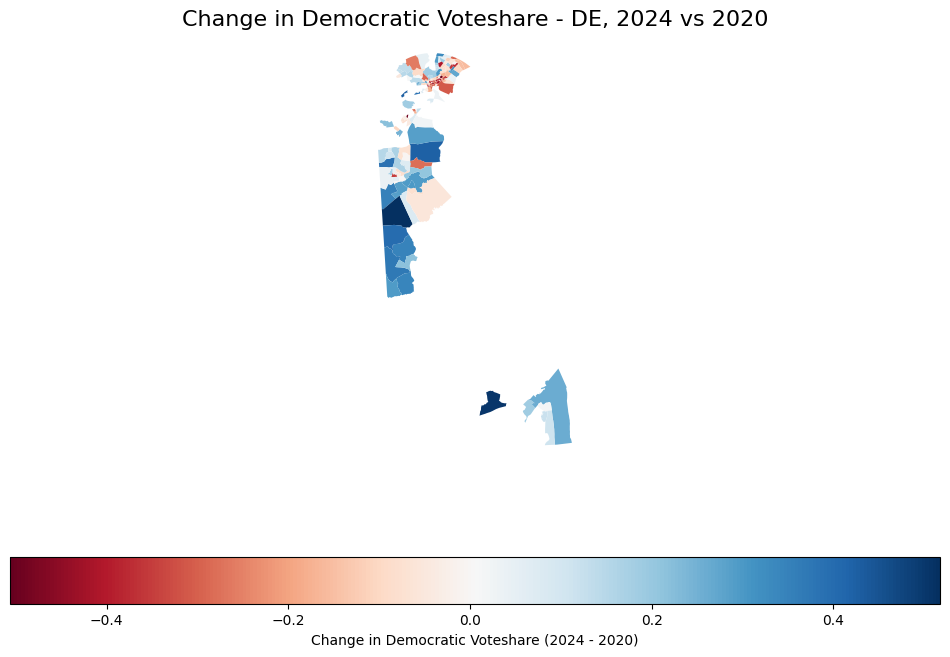

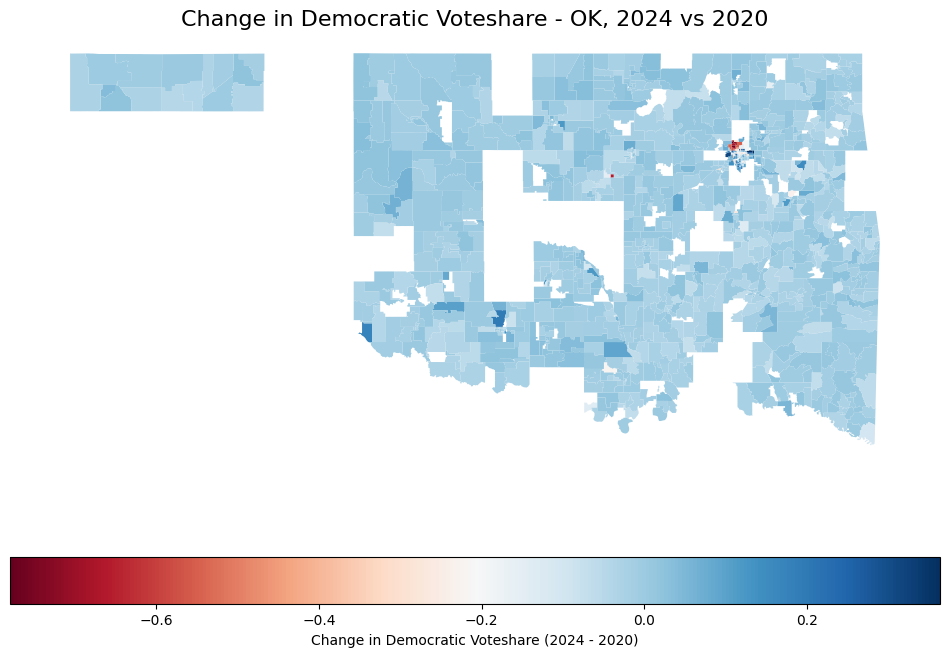

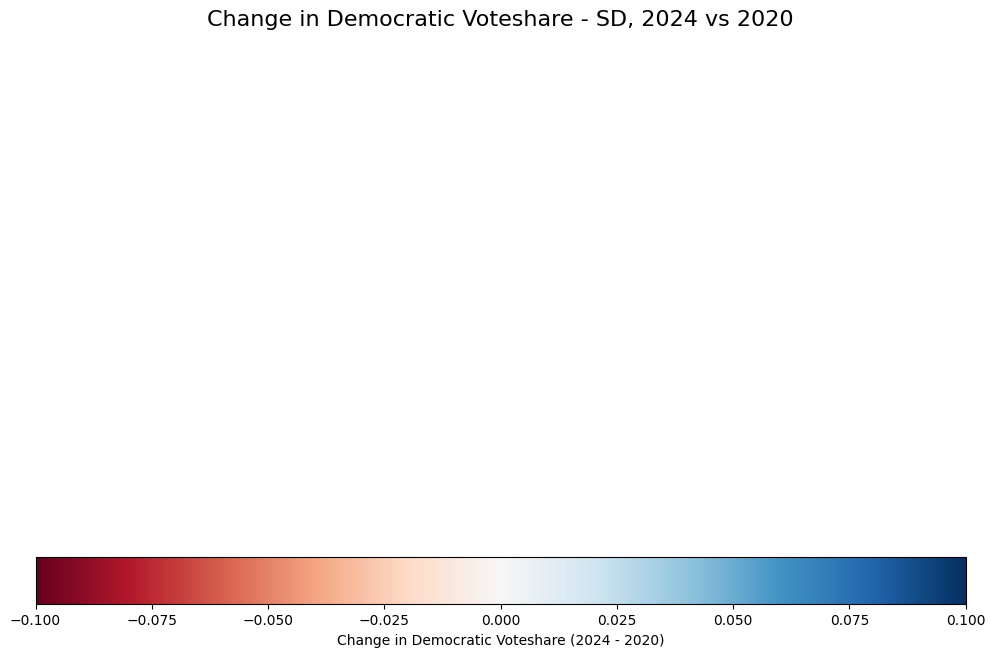

In [30]:
# Process and plot for Delaware, Oklahoma, and South Dakota
for state_abbr in ['de', 'ok', 'sd']:
    try:
        state_gdf = process_state(state_abbr)
        plot_delta_dem_vote(state_gdf, state_abbr)
    except Exception as e:
        print(f"Error processing {state_abbr.upper()}: {e}")

In [28]:
test = process_state('de')